In [1]:
from glob import glob
import json
import os
import sys
import time

from matplotlib import animation
from matplotlib.colorbar import Colorbar
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import mplcursors
import numpy as np
import pandas as pd
from scipy import interpolate, signal, stats, fftpack

#### Change this path to point to your code

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_evoked_traces, get_stim_events, find_nearest_ind
from tbd_eeg.tbd_eeg.data_analysis.eeg_preprocessing import qualitycheck_trials

In [5]:
%matplotlib notebook

#### Plot electrodes

### Load experiment

In [6]:
recfolder = r'F:\GAT1_EEG_pilot\mouse645606\EEGNPXspont_estim_2022-12-20_12-26-39\experiment1\recording1'
# exp = EEGexp(recfolder, preprocess=True, make_stim_csv=True)
exp = EEGexp(recfolder, preprocess=False, make_stim_csv=False)

Experiment type: electrical stimulation


In [7]:
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\GAT1-KO_analyses', 'mouse' + exp.mouse)
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)

exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

EEGNPXspont_estim


### Load EEG data

In [8]:
eeg_data, eeg_ts = exp.load_eegdata()
eeg_data = eeg_data * 1E-3 # convert to mV
eeg_chs = np.arange(0, eeg_data.shape[1])

bad_chs = []
GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])

In [9]:
print(eeg_ts[0])
print(eeg_ts[-1])

52.67653295206478
4437.547815569076


In [10]:
bpb, bpa = signal.butter(3, np.array([0.5, 50])/(exp.ephys_params['EEG']['sample_rate']/2), btype='bandpass')
filt_data = signal.filtfilt(bpb, bpa, eeg_data, axis=0)

### Load running speed

### Load SWDs

In [11]:
auto_annot_file = os.path.join(exp.data_folder, r'autoSWDs_v1.pkl')
if os.path.exists(auto_annot_file):
    print('Whoope there it is')
    autoSWD_df = pd.read_pickle(auto_annot_file)
else:
    print('Oops, you forgot to run the auto annotation notebook')

Whoope there it is


In [12]:
autoSWD_df.head()

,onset,offset,duration,spike_count,SWD_spike_times
0,62.907683,65.411671,2.503988,19,"[62.90768339318237, 63.042882738287446, 63.158..."
1,66.102868,68.190058,2.087190,16,"[66.1028679159616, 66.20286743157186, 66.30486..."
2,73.099234,74.083229,0.983995,9,"[73.09923402611828, 73.21323347391399, 73.3440..."
3,78.675207,81.261194,2.585987,17,"[78.67520701654675, 78.80320639652788, 78.9444..."
4,83.168785,84.357979,1.189194,10,"[83.16878525000968, 83.2935846454913, 83.42478..."


Print some stats

In [13]:
print('Number of SWDs in {:d} min recording: {:d} events'.format(int((eeg_ts[-1]-eeg_ts[0])/60), len(autoSWD_df)))
print('Average SWD duration: {:.1f} s [min={:.1f}, max={:.1f}]'.format(
    np.mean(autoSWD_df['duration'].values), np.min(autoSWD_df['duration'].values), np.max(autoSWD_df['duration'].values)))
print('Total time spent in SWD: {:.1f} min'.format(np.sum(autoSWD_df['duration'].values)/60))

Number of SWDs in 73 min recording: 829 events
Average SWD duration: 2.8 s [min=0.5, max=11.5]
Total time spent in SWD: 39.3 min


### Load stim log, if exists

In [14]:
if os.path.exists(exp.stimulus_log_file):
    stim_log = pd.read_csv(exp.stimulus_log_file)
else:
    print('No stim log for this experiment')

In [15]:
stim_log.head()

,stim_type,parameter,duration,onset,offset,sweep,mean_speed,resting_trial,SWD,good
0,biphasic,50,0.0004,3004.42943,3004.42983,0,10.281199,False,True,True
1,biphasic,50,0.0004,3025.43502,3025.43542,0,5.057074,False,True,True
2,biphasic,50,0.0004,3044.45591,3044.45631,0,0.000000,True,True,True
3,biphasic,50,0.0004,3064.48025,3064.48065,0,0.432813,False,True,True
4,biphasic,50,0.0004,3085.27708,3085.27748,0,4.700194,False,False,True


### Plot example EEG, running, and SWD events

### Add running speed and SWD events to stim_log

### Plot stim in SWD and not

## Plot some window of all channels

In [17]:
plot_window = [1350., 1450.] # choose values in s, must match master timestamp values

plot_inds = np.nonzero((eeg_ts > plot_window[0]) & (eeg_ts < plot_window[1]))[0]

In [18]:
pSWDs = autoSWD_df[(autoSWD_df['onset'] > plot_window[0]) & (autoSWD_df['onset'] < plot_window[1])]

<IPython.core.display.Javascript object>


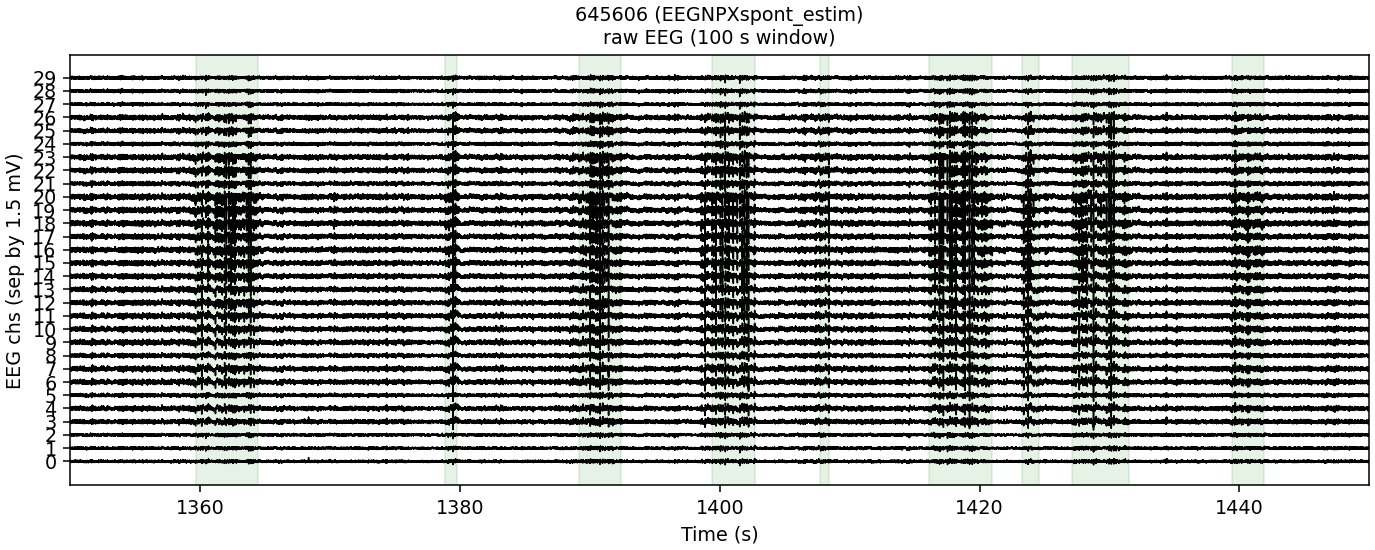

In [19]:
sep = 1.5 # mV, for visual 0.05

fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)
for chi in eeg_chs:
    if chi in GOOD_CHS:
        trace_color = 'k'
    else:
        trace_color = 'r'
    ax.plot(eeg_ts[plot_inds], eeg_data[plot_inds, chi] + sep*chi, color=trace_color, linewidth=0.8)
    
for indi, SWDi in pSWDs.iterrows():
    ax.axvspan(SWDi.onset, SWDi.offset, color='g', alpha=0.1)

ax.set_xlim(plot_window)
ax.set_xlabel('Time (s)')
ax.set_yticks(np.arange(0, sep*(chi+1), sep))
ax.set_yticklabels(eeg_chs)
ax.set_ylabel('EEG chs (sep by {:.1f} mV)'.format(sep))
ax.set_title('{} ({})\nraw EEG ({:d} s window)'.format(exp.mouse, exp_tag, int(plot_window[1]-plot_window[0])))

### SAVE ###
fig_name = '{}_rawEEGstack_{:d}-{:d}s.png'.format(exp_tag, int(plot_window[0]), int(plot_window[1]))
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

Apply a bandpass filter.

<IPython.core.display.Javascript object>


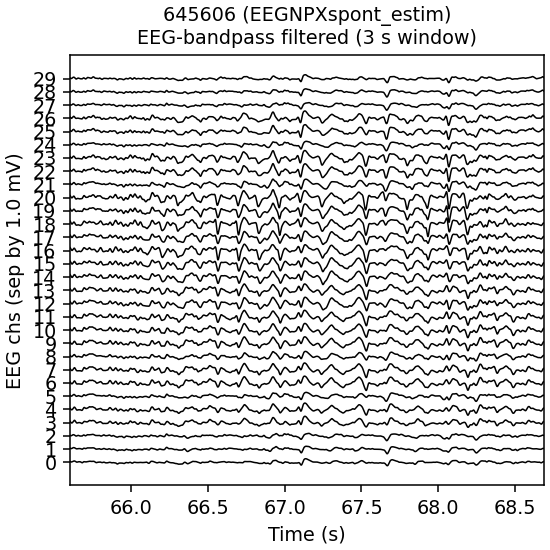

In [29]:
plot_event = autoSWD_df.iloc[1]
deltat = 0.5
sep = 1. # mV
plot_window = [plot_event.onset - deltat, plot_event.offset + deltat]
plot_inds = np.nonzero((eeg_ts > plot_window[0]) & (eeg_ts < plot_window[1]))[0]

fig, ax = plt.subplots(figsize=(4, 4), constrained_layout=True)
for chi in eeg_chs:
    if chi in GOOD_CHS:
        trace_color = 'k'
    else:
        trace_color = 'r'
    ax.plot(eeg_ts[plot_inds], filt_data[plot_inds, chi] + sep*chi, color=trace_color, linewidth=0.8)

ax.set_xlim(plot_window)
ax.set_xlabel('Time (s)')
ax.set_yticks(np.arange(0, sep*(chi+1), sep))
ax.set_yticklabels(eeg_chs)
ax.set_ylabel('EEG chs (sep by {:.1f} mV)'.format(sep))
ax.set_title('{} ({})\nEEG-bandpass filtered ({:d} s window)'.format(exp.mouse, exp_tag, int(plot_window[1]-plot_window[0])))

### SAVE ###
fig_name = '{}_filtEEGstack_{:d}-{:d}s.png'.format(exp_tag, int(plot_window[0]), int(plot_window[1]))
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

### Spatial interpolation

In [14]:
## Create the EEG mesh ##
ml = np.linspace(-5, 5, 100)
ap = np.linspace(-5, 3, 100)
ML, AP = np.meshgrid(ml, ap)

In [15]:
plot_event = autoSWD_df.iloc[1]
deltat = 0.1
plot_window = [plot_event.onset - deltat, plot_event.offset + deltat]
plot_inds = np.nonzero((eeg_ts > plot_window[0]) & (eeg_ts < plot_window[1]))[0]
frameinds = plot_inds[::5]

ctx_EEG_timeseries = []
for indi in frameinds:
    ctx_EEG_timeseries.append(interpolate.griddata(
        (EEGexp.EEG_channel_coordinates['ML'][GOOD_CHS], EEGexp.EEG_channel_coordinates['AP'][GOOD_CHS]),
        filt_data[indi, :], (ML, AP), method='cubic',
    ))
spatiotempEEG = np.array(ctx_EEG_timeseries)

In [16]:
spatiotempEEG.shape

(1144, 100, 100)

In [17]:
print(np.min(filt_data[plot_inds, :]))
print(np.max(filt_data[plot_inds, :]))

-0.9344042816454302
0.6011608849637022


Plot and animate

<IPython.core.display.Javascript object>


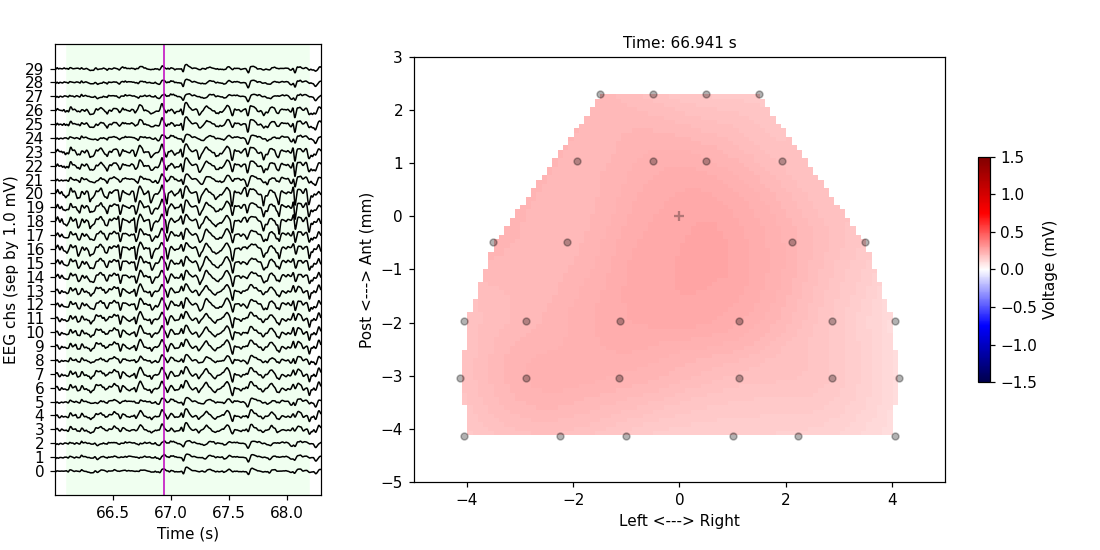

In [18]:
fig = plt.figure(figsize=(10, 5))
gs = fig.add_gridspec(ncols=2, nrows=1, top=0.92, bottom=0.1, left=0.05, right=0.98, wspace=0.2, width_ratios=[1,2.5])
initframe = 0

sep = 1. # mV

## Plot one ch with moving vertical line ##
chax = fig.add_subplot(gs[0])
chax.axvspan(plot_event.onset, plot_event.offset, color='honeydew')
for chi in eeg_chs:
    chax.plot(eeg_ts[plot_inds], filt_data[plot_inds, chi] + sep*chi, color='k', linewidth=1)
chline = chax.axvline(x=eeg_ts[frameinds[initframe]], color='m', linewidth=1)
chax.set_xlim(plot_window)
chax.set_xlabel('Time (s)')
chax.set_yticks(np.arange(0, sep*(chi+1), sep))
chax.set_yticklabels(eeg_chs)
chax.set_ylabel('EEG chs (sep by {:.1f} mV)'.format(sep))

## Plot heatmap ##
hmax = fig.add_subplot(gs[1])
sptp = hmax.imshow(
    spatiotempEEG[0,:,:], cmap='seismic', vmin=-1.5, vmax=1.5,
    origin='lower', interpolation='none', extent=(ml[0], ml[-1], ap[0], ap[-1]),
)
hmax.scatter(
    EEGexp.EEG_channel_coordinates['ML'][GOOD_CHS], EEGexp.EEG_channel_coordinates['AP'][GOOD_CHS],
    c='k', alpha=0.3, marker='o', s=20
)
hmax.scatter(0, 0, marker='+', color='k', s=50, alpha=0.3)
hmax.set_aspect('equal')
hmax.set_ylabel('Post <---> Ant (mm)')
hmax.set_xlabel('Left <---> Right')

cb = fig.colorbar(sptp, ax=hmax, shrink=.5, aspect=20)
cb.set_label('Voltage (mV)')
hmax.set_title('Time: {:.3f} s'.format(eeg_ts[frameinds[initframe]]))

## animate function ##
def animate(i):
    chline.set_data([eeg_ts[frameinds[i]], eeg_ts[frameinds[i]]], [0, 1])
    sptp.set_data(spatiotempEEG[i,:,:])
    hmax.set_title('Time: {:.3f} s'.format(eeg_ts[frameinds[i]]))

## animate it ##
anim = animation.FuncAnimation(fig, animate, init_func=None, frames=frameinds.shape[0], interval=20, blit=False)

movie_name = os.path.join(plotsavedir, '{}_spatiotempEEG_{:d}-{:d}s.mp4'.format(exp_tag, int(plot_window[0]), int(plot_window[1])))
anim.save(movie_name, writer='ffmpeg', fps=12, extra_args=['-vcodec', 'h264'], dpi=300, bitrate=-1) # 'libx264'

<IPython.core.display.Javascript object>


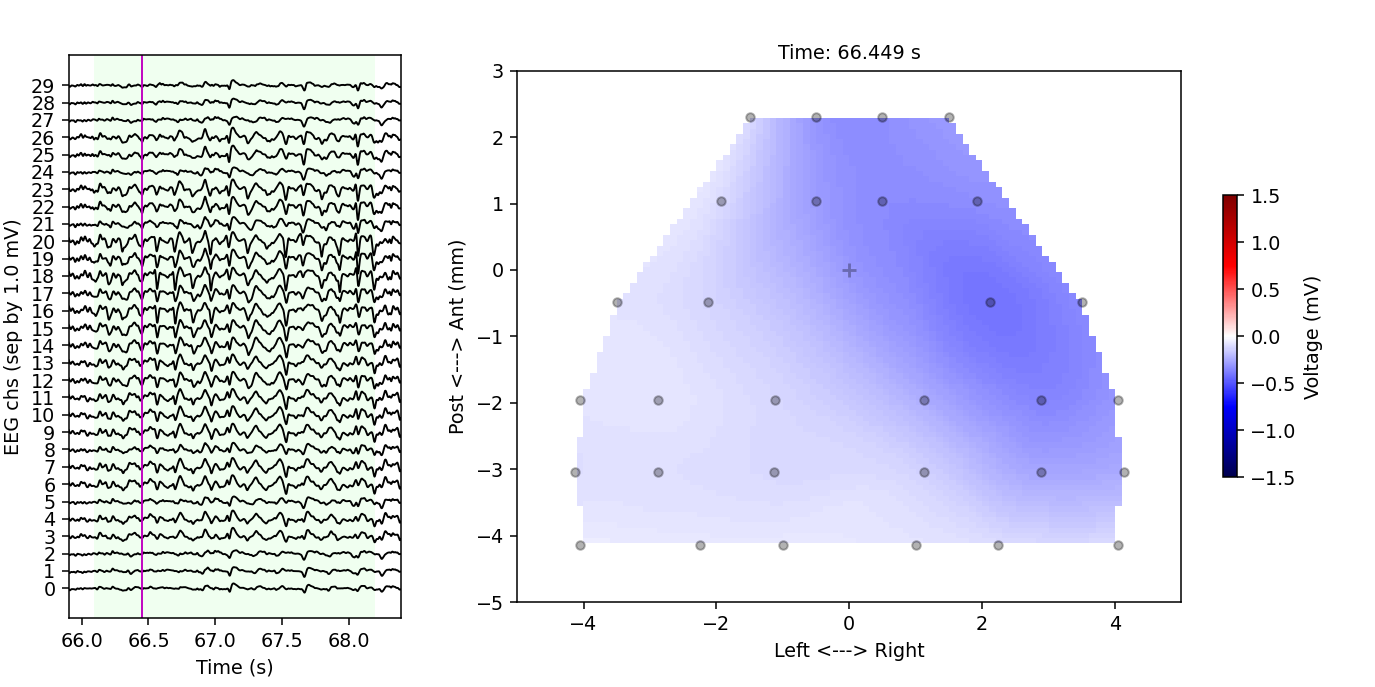

In [18]:
fig = plt.figure(figsize=(10, 5))
gs = fig.add_gridspec(ncols=2, nrows=1, top=0.92, bottom=0.1, left=0.05, right=0.98, wspace=0.2, width_ratios=[1,2.5])
initframe = 0

sep = 1. # mV

## Plot one ch with moving vertical line ##
chax = fig.add_subplot(gs[0])
chax.axvspan(plot_event.onset, plot_event.offset, color='honeydew')
for chi in eeg_chs:
    chax.plot(eeg_ts[plot_inds], filt_data[plot_inds, chi] + sep*chi, color='k', linewidth=1)
chline = chax.axvline(x=eeg_ts[frameinds[initframe]], color='m', linewidth=1)
chax.set_xlim(plot_window)
chax.set_xlabel('Time (s)')
chax.set_yticks(np.arange(0, sep*(chi+1), sep))
chax.set_yticklabels(eeg_chs)
chax.set_ylabel('EEG chs (sep by {:.1f} mV)'.format(sep))

## Plot heatmap ##
hmax = fig.add_subplot(gs[1])
sptp = hmax.imshow(
    spatiotempEEG[0,:,:], cmap='seismic', vmin=-1.5, vmax=1.5,
    origin='lower', interpolation='none', extent=(ml[0], ml[-1], ap[0], ap[-1]),
)
hmax.scatter(
    EEGexp.EEG_channel_coordinates['ML'][GOOD_CHS], EEGexp.EEG_channel_coordinates['AP'][GOOD_CHS],
    c='k', alpha=0.3, marker='o', s=20
)
hmax.scatter(0, 0, marker='+', color='k', s=50, alpha=0.3)
hmax.set_aspect('equal')
hmax.set_ylabel('Post <---> Ant (mm)')
hmax.set_xlabel('Left <---> Right')

cb = fig.colorbar(sptp, ax=hmax, shrink=.5, aspect=20)
cb.set_label('Voltage (mV)')
hmax.set_title('Time: {:.3f} s'.format(eeg_ts[frameinds[initframe]]))

## animate function ##
def animate(i):
    chline.set_data([eeg_ts[frameinds[i]], eeg_ts[frameinds[i]]], [0, 1])
    sptp.set_data(spatiotempEEG[i,:,:])
    hmax.set_title('Time: {:.3f} s'.format(eeg_ts[frameinds[i]]))

## animate it ##
anim = animation.FuncAnimation(fig, animate, init_func=None, frames=frameinds.shape[0], interval=20, blit=False)

movie_name = os.path.join(plotsavedir, '{}_spatiotempEEG_{:d}-{:d}s_test.wmv'.format(exp_tag, int(plot_window[0]), int(plot_window[1])))
# anim.save(movie_name, writer='ffmpeg', fps=12, extra_args=['-vcodec', 'libx264'], dpi=500, bitrate=-1)
# anim.to_html5_video()

# saving to m4 using ffmpeg writer
writervideo = animation.FFMpegWriter(fps=12)
anim.save(movie_name, writer=writervideo)

### Power spectrum

In [17]:
## Process the power spectrum across the whole recording ##
frex, Pxx = signal.welch(
    eeg_data, exp.ephys_params['EEG']['sample_rate'], nperseg=2 * exp.ephys_params['EEG']['sample_rate'], axis=0
)

<IPython.core.display.Javascript object>


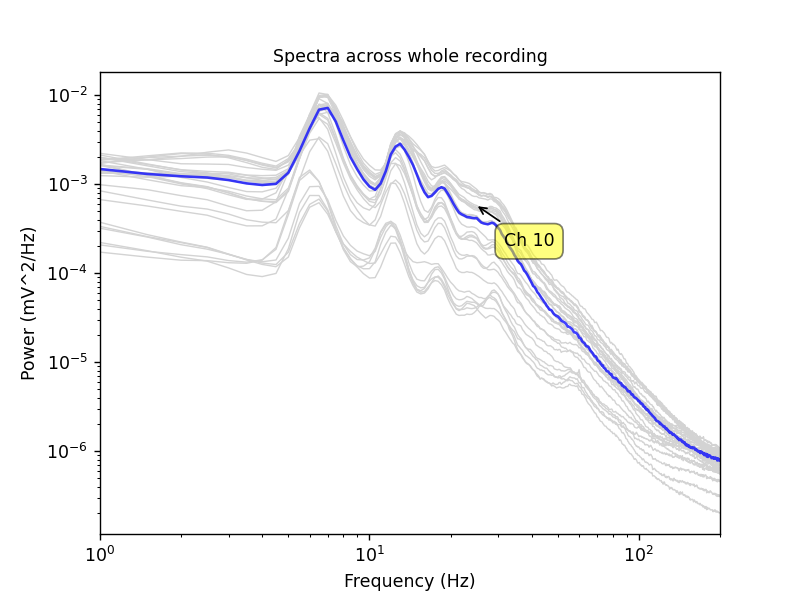

Text(0.5, 1.0, 'Spectra across whole recording')

In [18]:
frinds = frex < 200

fig, ax = plt.subplots()

spectra = ax.loglog(frex[frinds], Pxx[frinds,:], color='lightgray', linewidth=0.8)
for ind, spec in enumerate(spectra):
    spec.set_label('Ch {}'.format(ind))
cursor = mplcursors.cursor(spectra, hover=True)
cursor.connect('add', lambda sel: sel.annotation.set_text(sel.artist.get_label()))

ax.loglog(frex[frinds], np.median(Pxx, axis=1)[frinds], color='b', linewidth=1.5, alpha=0.75)
ax.set_xlim([1, 200])

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (mV^2/Hz)')
ax.set_title('Spectra across whole recording')

<IPython.core.display.Javascript object>


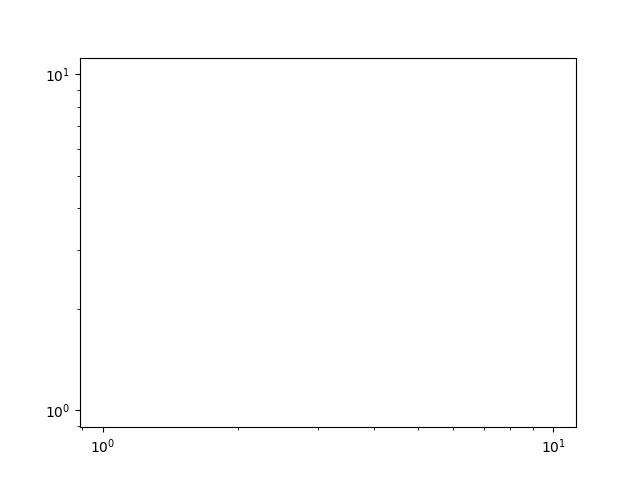

ValueError: array([[5.00000000e-01, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [4.37254902e-01, 9.84002783e-02, 9.98785992e-01, 1.00000000e+00],
       [3.66666667e-01, 2.07911691e-01, 9.94521895e-01, 1.00000000e+00],
       [2.96078431e-01, 3.14869589e-01, 9.87201840e-01, 1.00000000e+00],
       [2.25490196e-01, 4.17960345e-01, 9.76848318e-01, 1.00000000e+00],
       [1.54901961e-01, 5.15917826e-01, 9.63493144e-01, 1.00000000e+00],
       [9.21568627e-02, 5.97707459e-01, 9.49134944e-01, 1.00000000e+00],
       [2.15686275e-02, 6.82748855e-01, 9.30229309e-01, 1.00000000e+00],
       [4.90196078e-02, 7.59404917e-01, 9.08465272e-01, 1.00000000e+00],
       [1.19607843e-01, 8.26734175e-01, 8.83909710e-01, 1.00000000e+00],
       [1.90196078e-01, 8.83909710e-01, 8.56638078e-01, 1.00000000e+00],
       [2.60784314e-01, 9.30229309e-01, 8.26734175e-01, 1.00000000e+00],
       [3.23529412e-01, 9.61825643e-01, 7.98017227e-01, 1.00000000e+00],
       [3.94117647e-01, 9.86200747e-01, 7.63398283e-01, 1.00000000e+00],
       [4.64705882e-01, 9.98463604e-01, 7.26433574e-01, 1.00000000e+00],
       [5.35294118e-01, 9.98463604e-01, 6.87236686e-01, 1.00000000e+00],
       [6.05882353e-01, 9.86200747e-01, 6.45928062e-01, 1.00000000e+00],
       [6.76470588e-01, 9.61825643e-01, 6.02634636e-01, 1.00000000e+00],
       [7.39215686e-01, 9.30229309e-01, 5.62592752e-01, 1.00000000e+00],
       [8.09803922e-01, 8.83909710e-01, 5.15917826e-01, 1.00000000e+00],
       [8.80392157e-01, 8.26734175e-01, 4.67657593e-01, 1.00000000e+00],
       [9.50980392e-01, 7.59404917e-01, 4.17960345e-01, 1.00000000e+00],
       [1.00000000e+00, 6.82748855e-01, 3.66978792e-01, 1.00000000e+00],
       [1.00000000e+00, 5.97707459e-01, 3.14869589e-01, 1.00000000e+00],
       [1.00000000e+00, 5.15917826e-01, 2.67733003e-01, 1.00000000e+00],
       [1.00000000e+00, 4.17960345e-01, 2.13933083e-01, 1.00000000e+00],
       [1.00000000e+00, 3.14869589e-01, 1.59475791e-01, 1.00000000e+00],
       [1.00000000e+00, 2.07911691e-01, 1.04528463e-01, 1.00000000e+00],
       [1.00000000e+00, 9.84002783e-02, 4.92599411e-02, 1.00000000e+00],
       [1.00000000e+00, 1.22464680e-16, 6.12323400e-17, 1.00000000e+00]]) is not a valid value for color

In [69]:
frinds = frex < 200

fig, ax = plt.subplots()

colors = plt.cm.rainbow(np.linspace(0, 1, Pxx.shape[1]))
spectra = ax.loglog(frex[frinds], Pxx[frinds,:], c=colors, linewidth=0.8)

ax.loglog(frex[frinds], np.median(Pxx, axis=1)[frinds], color='k', linewidth=1.5, alpha=0.75)
ax.set_xlim([1, 200])

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (mV^2/Hz)')
ax.set_title('Spectra across whole recording')

### Plotting

Plot the visual evoked response across all electrodes. This plots all electrodes in the array layout, with bad chs in red. You can choose to plot:
- 'raw': raw signals, averaged across all trials
- 'filtered': bandpass filtered signals, averaged across all trials
- 'common_averaged': raw signals that have been common average referenced to all good chs, then filtered and averaged across all trials

<IPython.core.display.Javascript object>


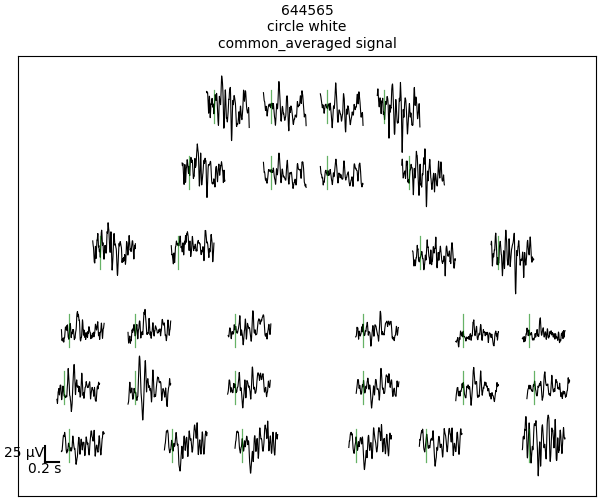

In [35]:
plot_stim_type = 'circle'
plot_stim_param = 'white'
plot_sweep = 0
plot_traces = 'common_averaged' # choose: 'raw', 'filtered', or 'common_averaged'

# if remove_bad_trials:
#     tag = 'good'
# else:
#     tag = 'all'

prex = .1 # s before stim to plot
postx = .5 # s after stim to plot
xmult = 0.8 # changes horizontal distance between traces, usually 0.8
ymult = 80 # changes vertical distance between traces, usually 100 for VEPs

timex = avg_traces[plot_stim_type][plot_stim_param][plot_sweep][plot_traces][0]
plottraces = avg_traces[plot_stim_type][plot_stim_param][plot_sweep][plot_traces][1]
pinds = np.squeeze(np.argwhere((timex >= -prex) & (timex <= postx)))

fig, ax = plt.subplots(figsize=(6, 5), constrained_layout=True)
for chi in range(len(exp.EEG_channel_coordinates)):
    if chi in GOOD_CHS:
        trace_color = 'k'
    else:
        trace_color = 'r'
    ax.plot(
        timex[pinds] + (exp.EEG_channel_coordinates['ML'].iloc[chi] * xmult),
        plottraces[pinds, chi] + (exp.EEG_channel_coordinates['AP'].iloc[chi] * ymult),
        trace_color,
        linewidth=0.8
    )
    # this adds a vertical green line at stim onset time #
    ax.plot([0.+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult),
             0.+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult)],
            [-25+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult),
             25+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult)],
            color='g', linewidth=0.9, alpha=0.6)
#     ax.plot([0.1+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult),
#              0.1+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult)],
#             [-25+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult),
#              25+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult)],
#             color='r', linewidth=0.9, alpha=0.6)
    if chi == 0:
        mx = timex[0] + exp.EEG_channel_coordinates['ML'].iloc[chi] * xmult * 0.95
        my = exp.EEG_channel_coordinates['AP'].iloc[chi] * ymult

## This plots a scale bar in the bottom left corner ##
x_len = .2 # x scale bar length in ms
y_len = 25 # y scale bar length in uV, for VEP: 25
ax.plot([mx, mx+x_len], [my-y_len, my-y_len], 'k') # horizontal scale bar
ax.plot([mx, mx], [my-y_len, my], 'k') # vertical scale bar
ax.annotate(('{} s'.format(x_len)), xy=(mx,my-y_len), xycoords='data', ha='center', va='top')
ax.annotate(('{} \u03BCV'.format(y_len)), xy=(mx,my), xycoords='data', ha='right', va='top')

## Set title ##
ax.set_title('{}\n{} {}\n{} signal'.format(exp.mouse, plot_stim_type, str(plot_stim_param), plot_traces))
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.tick_params(axis='y', left=False, labelleft=False)

### SAVE: this will save the figure in the recording1 folder ###
fig_name = '{}VEPs_{}{}_arrayplot_sweep{:d}.png'.format(plot_traces, plot_stim_type, str(plot_stim_param), plot_sweep)

## UNCOMMENT TO SAVE THE FIGURE ##
fig.savefig(os.path.join(recfolder, fig_name), transparent=False)

In [35]:
snr_dur = 0.2

binds = np.squeeze(np.argwhere((timex >= -snr_dur) & (timex < 0)))
rinds = np.squeeze(np.argwhere((timex > 0) & (timex <= snr_dur)))

base_power = np.mean(np.square(plottraces[binds, :]), axis=0)
resp_power = np.mean(np.square(plottraces[rinds, :]), axis=0)
snrs = np.sqrt(resp_power / base_power)
print(snrs)
print(np.mean(snrs))

[1.95017782 5.24227399 1.42381525 5.16199239 4.37454255 4.24241459
 3.51264115 1.21593842 3.83742894 1.8955301  1.89893429 1.8067833
 0.81062434 1.23805703 0.87227716 0.9842449  2.95423934 1.29269561
 4.07347692 2.26632062 1.86270402 1.81373157 0.51786046 0.52933825
 2.45093971 0.39612949 0.46196817 2.47845535 0.79152483 0.52708515]
2.0961381906796692


#### Same plot above, but as a butterfly plot

<IPython.core.display.Javascript object>


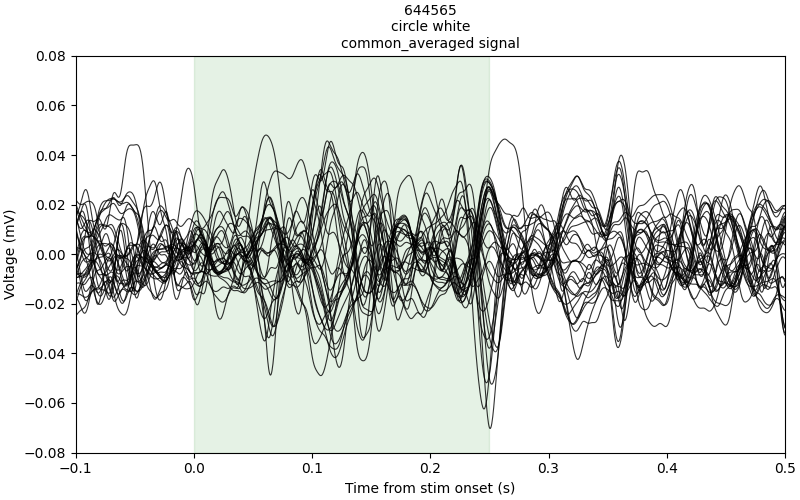

In [36]:
ylimit = 0.08 # mV, for visual 0.05

fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)
for chi in GOOD_CHS:
    ax.plot(timex[pinds], plottraces[pinds, chi]/1000, color='k', linewidth=0.8, alpha=0.8)
ax.axvspan(0., 0.25, color='g', alpha=0.1)

ax.set_xlim([-prex, postx])
ax.set_ylim([-ylimit, ylimit])
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Voltage (mV)')
ax.set_title('{}\n{} {}\n{} signal'.format(exp.mouse, plot_stim_type, str(plot_stim_param), plot_traces))

### SAVE: this will save the figure in the recording1 folder ###
fig_name = '{}VEPs_{}{}_butterflyplot_sweep{:d}.png'.format(plot_traces, plot_stim_type, str(plot_stim_param), plot_sweep)
fig.savefig(os.path.join(recfolder, fig_name), transparent=False)

#### Same plot, but with electrodes vertically stacked

<IPython.core.display.Javascript object>


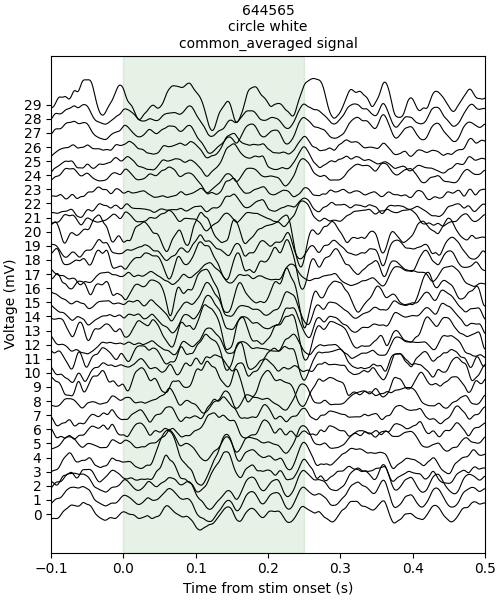

In [37]:
sep = 0.025 # mV, for visual 0.05

fig, ax = plt.subplots(figsize=(5, 6), constrained_layout=True)
for chi in range(len(exp.EEG_channel_coordinates)):
    if chi in GOOD_CHS:
        trace_color = 'k'
    else:
        trace_color = 'r'
    ax.plot(timex[pinds], plottraces[pinds, chi]/1000 + sep*chi, color=trace_color, linewidth=0.8)
ax.axvspan(0., 0.25, color='g', alpha=0.1)

ax.set_xlim([-prex, postx])
ax.set_xlabel('Time from stim onset (s)')
ax.set_yticks(np.arange(0, sep*(chi+1), sep))
ax.set_yticklabels(range(len(exp.EEG_channel_coordinates)))
ax.set_ylabel('Voltage (mV)')
ax.set_title('{}\n{} {}\n{} signal'.format(exp.mouse, plot_stim_type, str(plot_stim_param), plot_traces))

### SAVE: this will save the figure in the recording1 folder ###
fig_name = '{}VEPs_{}{}_stackedplot_sweep{:d}.png'.format(plot_traces, plot_stim_type, str(plot_stim_param), plot_sweep)
fig.savefig(os.path.join(recfolder, fig_name), transparent=False)

### Plot whole traces

<IPython.core.display.Javascript object>


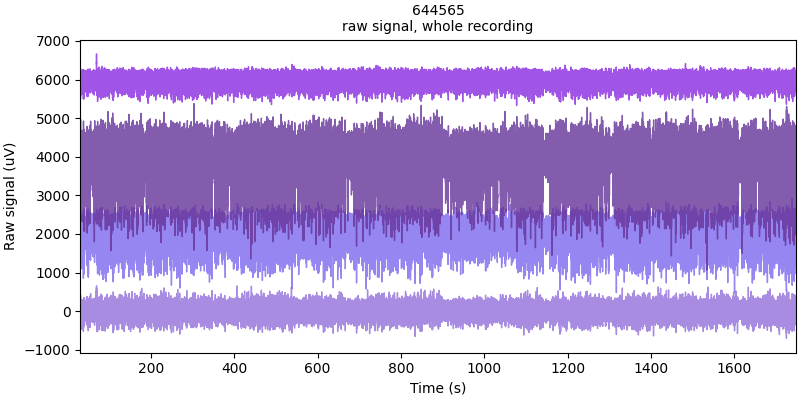

In [30]:
plot_chs = [0,3,13,27]
chcolors = ['mediumpurple','mediumslateblue','rebeccapurple','blueviolet','darkorchid','darkviolet']
# chcolors = ['crimson','blue','gold','green','darkviolet','deeppink']

offset = 2000 # 500
fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)

for i, chi in enumerate(plot_chs):
    ax.plot(eeg_ts, eeg_data[:,chi] + i*offset, color=chcolors[i], linewidth=1, alpha=0.8, label=('Ch {:d}'.format(chi)))

ax.set_xlim((eeg_ts[0], eeg_ts[-1]))
# ax.set_ylim((-500, 2200))

ax.set_xlabel('Time (s)')
ax.set_ylabel('Raw signal (uV)')
ax.set_title('{}\nraw signal, whole recording'.format(exp.mouse))
# ax.legend()

### SAVE: this will save the figure in the recording1 folder ###
fig_name = 'whole_raw_signals.png'
fig.savefig(os.path.join(recfolder, fig_name), transparent=True)